In [1]:
import numpy as np
import pandas as pd

path = '/data/examples/flower_classification/'
#path = 'D:\\AI\\where_am_i\\'

#TransferLearning開關
isTransferLearning = True

#input img size, 根據base_model調整圖片size
resize = (224, 224)

#output labels
num_classes = 5


<h2>prepare data!</h2>

In [41]:

# make a label map
df = pd.read_csv(path + 'mapping.csv', header=None)
df.head()


,0,1
0,dirs,class
1,daisy,0
2,dandelion,1
3,rose,2
4,sunflower,3


In [42]:
df=df.drop(index=0)
df[1]=df[1].astype(np.int32)
yMap = dict(zip(df[0], df[1]))
yRMap = dict(zip(df[1], df[0]))
print(len(yMap), yMap)

5 {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}


In [43]:
yRMap

{0: 'daisy', 1: 'dandelion', 2: 'rose', 3: 'sunflower', 4: 'tulip'}

In [3]:
import os

# show file structure
for dirname, dirnames, filenames in os.walk(path+'train'):    
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

/data/examples/flower_classification/train/daisy/10140303196_b88d3d6cec.jpg
/data/examples/flower_classification/train/dandelion/10043234166_e6dd915111_n.jpg
/data/examples/flower_classification/train/rose/10090824183_d02c613f10_m.jpg
/data/examples/flower_classification/train/sunflower/10386503264_e05387e1f7_m.jpg
/data/examples/flower_classification/train/tulip/10094729603_eeca3f2cb6.jpg


In [4]:
import os
import pandas as pd

#make a image table
trainList = []
for dirname, dirnames, filenames in os.walk(path+'train'):    
    for filename in filenames:
        folderName = os.path.split(dirname)[-1]
        #print(os.path.join(dirname, filename), folderName)        
        row = []
        row.append(yMap[folderName])
        row.append(folderName)
        row.append(filename)
        row.append(os.path.join(dirname, filename))
        trainList.append(row)        
        
trainDf = pd.DataFrame(trainList, columns=['label','folder','file','path'])          
print(trainDf.shape)
trainDf.head()

(3823, 4)


,label,folder,file,path
0,0,daisy,10140303196_b88d3d6cec.jpg,/data/examples/flower_classification/train/dai...
1,0,daisy,10172379554_b296050f82_n.jpg,/data/examples/flower_classification/train/dai...
2,0,daisy,10172567486_2748826a8b.jpg,/data/examples/flower_classification/train/dai...
3,0,daisy,10172636503_21bededa75_n.jpg,/data/examples/flower_classification/train/dai...
4,0,daisy,10300722094_28fa978807_n.jpg,/data/examples/flower_classification/train/dai...


In [ ]:
#test img

import cv2
%matplotlib inline
import matplotlib.pyplot as plt

img = cv2.imread(trainDf['path'][3])
print('img.shape',img.shape)

img = cv2.resize(img, resize)
plt.imshow(img) #, cmap='gray'
print('img.shape',img.shape)
print('color dim:',img[0][0])


In [6]:
#圖檔變數值資料
def getXData(dataFrame):
    X = np.array([cv2.resize(cv2.imread(file), resize).astype(np.float32) for file in dataFrame['path']])
    print('X.shape', X.shape)
    print(X[0][0][0])
    if isTransferLearning:
        X[:,:,:,0] = (X[:,:,:,0] - 103.94) * 0.017
        X[:,:,:,1] = (X[:,:,:,1] - 116.78) * 0.017
        X[:,:,:,2] = (X[:,:,:,2] - 123.68) * 0.017
    else:
        X /= 255.
    
    print(X[0][0][0])
    return X

In [7]:
import keras

#圖片變數值資料
X = getXData(trainDf)

#one hot encoding Y
label = keras.utils.to_categorical(trainDf['label'], num_classes)

print(label.shape)
print(label[0])

Using TensorFlow backend.


X.shape (3823, 224, 224, 3)
[ 223.  216.  212.]
[ 2.02401996  1.68674016  1.50144005]
(3823, 5)
[ 1.  0.  0.  0.  0.]


In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    X, label, test_size=0.2) #default就會shuffle, 不用random_state=42

print(x_train.shape, y_train.shape,x_test.shape, y_test.shape)
print(x_train[0][0][0])
print(y_train[0:5])
print(x_train[0].shape)

(3058, 224, 224, 3) (3058, 5) (765, 224, 224, 3) (765, 5)
[-1.71598017 -1.18625998 -1.45656013]
[[ 1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.]]
(224, 224, 3)


<h2>build model!</h2>
model參考 https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py

DenseNet-Keras: https://github.com/flyyufelix/DenseNet-Keras/blob/master/test_inference.py

In [9]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import os

if isTransferLearning:
    #(224, 224)
    #base_model = keras.applications.mobilenetv2.MobileNetV2(input_shape=x_train[0].shape, alpha=1.0, depth_multiplier=1, include_top=False, weights='imagenet')    
    #base_model = keras.applications.densenet.DenseNet121(include_top=False, weights='imagenet', input_shape=x_train[0].shape)    
    base_model = keras.applications.densenet.DenseNet201(weights='imagenet', include_top=False, input_shape=x_train[0].shape)
    #base_model = keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=x_train[0].shape)
    #(299, 299)
    #base_model = keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet', input_shape=x_train[0].shape)
  

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D(data_format='channels_last')(x) #可比Flatten()少參數量
    x = Dropout(0.5)(x)

    # let's add a fully-connected layer
    #x = Dense(1024, activation='relu')(x)
    # and a logistic layer 
    predictions = Dense(num_classes, activation='softmax')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
   
    layerTransfer = False
    if layerTransfer:    
        #前面layer固定不train
        for layer in base_model.layers[0:-6]:
            layer.trainable = False
else:    
    # build our CNN model
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=x_train[0].shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))



In [10]:
#print(model.summary())
print(len(model.layers))

709


In [11]:
from keras import backend as K

trainable_count = int(
    np.sum([K.count_params(p) for p in set(model.trainable_weights)]))
non_trainable_count = int(
    np.sum([K.count_params(p) for p in set(model.non_trainable_weights)]))

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 18,331,589
Trainable params: 18,102,533
Non-trainable params: 229,056


In [12]:

#opt = keras.optimizers.Adam()
opt = keras.optimizers.Adam(lr=10e-6) #10e-6 = 0.00001
#opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
#opt = keras.optimizers.SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])



<h2>start training!</h2>

In [13]:

print(x_train.shape, y_train.shape,x_test.shape, y_test.shape)

print('Using real-time data augmentation.')
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

datagen.fit(x_train)


# Use ModelCheckpoint to save model and weights
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_trained_model.h5'
print(save_dir)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=0)

# earlystop
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=0)


batch_size = 25 #x_train.size / batch_size 就是每次epoch要跑的次數
epochs = 100

model_history = model.fit_generator(datagen.flow(x_train, y_train,
                             batch_size=batch_size),
                epochs=epochs,
                validation_data=(x_test, y_test),
                workers=4,
                callbacks=[earlystop, checkpoint])

# loading our save model
print("Loading trained model ", model_path)
modelBest = load_model(model_path)


# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])


if modelBest is not None:
    print('modelBest',modelBest)
    scores = modelBest.evaluate(x_test, y_test, verbose=1)
    print('modelBest loss:', scores[0])
    print('modelBest accuracy:', scores[1])
    model = modelBest

    
    

(3058, 224, 224, 3) (3058, 5) (765, 224, 224, 3) (765, 5)
Using real-time data augmentation.
/home/jovyan/murphy/midexam/saved_models
Epoch 1/100
123/123 [==============================] - 199s 2s/step - loss: 1.2333 - acc: 0.5143 - val_loss: 0.6204 - val_acc: 0.7843
Epoch 2/100
123/123 [==============================] - 55s 445ms/step - loss: 0.6296 - acc: 0.7684 - val_loss: 0.4188 - val_acc: 0.8614
Epoch 3/100
123/123 [==============================] - 56s 455ms/step - loss: 0.4801 - acc: 0.8236 - val_loss: 0.3338 - val_acc: 0.8876
Epoch 4/100
123/123 [==============================] - 56s 453ms/step - loss: 0.3758 - acc: 0.8666 - val_loss: 0.2922 - val_acc: 0.9020
Epoch 5/100
123/123 [==============================] - 56s 452ms/step - loss: 0.3253 - acc: 0.8878 - val_loss: 0.2637 - val_acc: 0.9124
Epoch 6/100
123/123 [==============================] - 56s 452ms/step - loss: 0.2684 - acc: 0.9096 - val_loss: 0.2394 - val_acc: 0.9137
Epoch 7/100
123/123 [==============================]

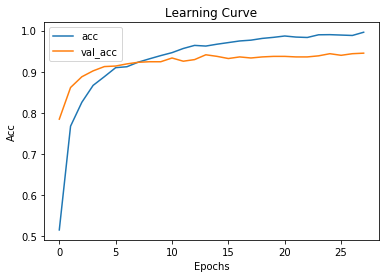

In [14]:
acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(acc, label="acc")
plt.plot(val_acc, label="val_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

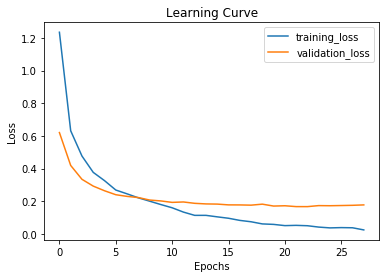

In [15]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [16]:
y_val_pred_prob = model.predict(x_test)
print(y_val_pred_prob.shape)
y_val_label = y_val_pred_prob.argmax(axis=-1)
y_test_label = y_test.argmax(axis=-1)

(765, 5)


In [17]:
crosstab = pd.crosstab(y_test_label, 
            y_val_label)
crosstab

col_0,0,1,2,3,4
row_0,,,,,
0,109,5,1,0,1
1,8,180,0,4,2
2,0,2,136,0,7
3,1,2,2,104,4
4,0,2,6,2,187


In [30]:
yRMap

{'0': 'daisy', '1': 'dandelion', '2': 'rose', '3': 'sunflower', '4': 'tulip'}

In [44]:
df = pd.DataFrame({'label':y_test_label, 'predict':y_val_label})
print(df.shape)

actualIndex, predictIndex = 2,4

print('actual:',yRMap[actualIndex], 'predict:',yRMap[predictIndex])

ngDf = df[(df.label == actualIndex) & (df.predict == predictIndex)]
ngDf

(765, 2)
actual: rose predict: tulip


,label,predict
21,2,4
55,2,4
368,2,4
417,2,4
496,2,4
662,2,4
734,2,4


In [ ]:
for ii in ngDf.index:
    print(ii)

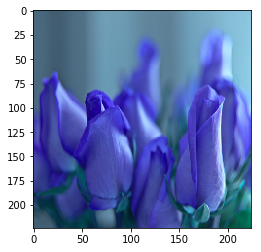

In [47]:
img = x_test[662]

img[:,:,0] = (img[:,:,0] / 0.017) + 103.94
img[:,:,1] = (img[:,:,1] / 0.017) + 116.78
img[:,:,2] = (img[:,:,2] / 0.017) + 123.68

img = img.astype(np.int32)

plt.imshow(img)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

w=10
h=10
fig=plt.figure(figsize=(20, 20))
columns = 4
rows = 5
i=1
for ii in ngDf.index:
    fig.add_subplot(rows, columns, i)
    i=i+1
    img = x_test[ii]

    img[:,:,0] = (img[:,:,0] / 0.017) + 103.94
    img[:,:,1] = (img[:,:,1] / 0.017) + 116.78
    img[:,:,2] = (img[:,:,2] / 0.017) + 123.68

    img = img.astype(np.int32)    
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

<h2>start predict!</h2>

In [49]:
# make test data
import os
import pandas as pd

testList = []
for dirname, dirnames, filenames in os.walk(path+'test'):    
    for filename in filenames:
        row = []
        row.append(filename.replace('.jpg',''))
        row.append(os.path.join(dirname, filename))
        testList.append(row)
        
testDf = pd.DataFrame(testList, columns=['id','path'])        
  
print(testDf.shape, testDf.iloc[0,0], testDf.iloc[0,1])

(500, 2) 100080576_f52e8ee070_n /data/examples/flower_classification/test/100080576_f52e8ee070_n.jpg


In [50]:
testDf.head()

,id,path
0,100080576_f52e8ee070_n,/data/examples/flower_classification/test/1000...
1,1008566138_6927679c8a,/data/examples/flower_classification/test/1008...
2,100930342_92e8746431_n,/data/examples/flower_classification/test/1009...
3,1022552002_2b93faf9e7_n,/data/examples/flower_classification/test/1022...
4,1022552036_67d33d5bd8_n,/data/examples/flower_classification/test/1022...


In [51]:

imgTest = getXData(testDf)    

if isTransferLearning:
    y_test_pred_prob = model.predict(imgTest)
    y_pred = y_test_pred_prob.argmax(axis=-1)
else:
    y_pred=model.predict_classes(imgTest)


print(y_pred.shape)

X.shape (500, 224, 224, 3)
[ 134.  135.  135.]
[ 0.51102     0.30974004  0.19244   ]
(500,)


In [53]:
# output result
out = pd.DataFrame()
out['id'] = testDf['id']
out['class'] = y_pred
print(out.shape)
out.to_csv('flower_submit.csv',index=False)

(500, 2)
